## Twitter Setiment Analysis 

### Part 3: Naive Bayes

The usual data-science workflow is to quickly train and evaluate several models before any further work (such as feature extraction) and with no hyperparameter tuning to select a few choice models for further work.

Since I'm running the project on a home laptop and have limited time, I'm going to start just by focusing on Naive Bayes, which is relatively fast. Testing every possible vectorization method would also take too long, so for the next classifers I'll have to rely on a bit of intuition gained with Naive Bayes.

### Load Pre-Processed Data

The timer decorator comes from Geir Arne Hjelle's [Real Python Tutorial](https://realpython.com/python-timer/#using-the-python-timer-decorator).

In [1]:
import os 
import time
import functools
import numpy as np
import scipy.sparse as sp

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [2]:
dirpath = os.path.join("..","data","3_processed","sentiment140")
filenames = ['X_text_bow'
            ,'X_tokn_bow'
            ,'X_filt_bow'
            ,'X_stem_bow'
            ,'X_lemm_bow'
            ,'X_text_tfidf'
            ,'X_tokn_tfidf'
            ,'X_filt_tfidf'
            ,'X_stem_tfidf'
            ,'X_lemm_tfidf'
            ,'X_text_log_tfidf'
            ,'X_tokn_log_tfidf'
            ,'X_filt_log_tfidf'
            ,'X_stem_log_tfidf'
            ,'X_lemm_log_tfidf']

filepaths = [os.path.join(dirpath, ''.join([filename, '.npz'])) for filename in filenames]

In [3]:
# load pre-processed featre vectors
@timer
def load_data():
    X_text_bow       = sp.load_npz(filepaths[0])
    X_tokn_bow       = sp.load_npz(filepaths[1])
    X_filt_bow       = sp.load_npz(filepaths[2])
    X_stem_bow       = sp.load_npz(filepaths[3])
    X_lemm_bow       = sp.load_npz(filepaths[4])
    X_text_tfidf     = sp.load_npz(filepaths[5])
    X_tokn_tfidf     = sp.load_npz(filepaths[6])
    X_filt_tfidf     = sp.load_npz(filepaths[7])
    X_stem_tfidf     = sp.load_npz(filepaths[8])
    X_lemm_tfidf     = sp.load_npz(filepaths[9])
    X_text_log_tfidf = sp.load_npz(filepaths[10])
    X_tokn_log_tfidf = sp.load_npz(filepaths[11])
    X_filt_log_tfidf = sp.load_npz(filepaths[12])
    X_stem_log_tfidf = sp.load_npz(filepaths[13])
    X_lemm_log_tfidf = sp.load_npz(filepaths[14])
    
    return (  X_text_bow      
            , X_tokn_bow      
            , X_filt_bow      
            , X_stem_bow  
            , X_lemm_bow
            , X_text_tfidf    
            , X_tokn_tfidf    
            , X_filt_tfidf    
            , X_stem_tfidf  
            , X_lemm_tfidf
            , X_text_log_tfidf
            , X_tokn_log_tfidf
            , X_filt_log_tfidf
            , X_stem_log_tfidf
            , X_lemm_log_tfidf
            )

In [4]:
( X_text_bow      
, X_tokn_bow      
, X_filt_bow      
, X_stem_bow  
, X_lemm_bow
, X_text_tfidf    
, X_tokn_tfidf    
, X_filt_tfidf    
, X_stem_tfidf  
, X_lemm_tfidf
, X_text_log_tfidf
, X_tokn_log_tfidf
, X_filt_log_tfidf
, X_stem_log_tfidf
, X_lemm_log_tfidf
) = load_data()

Elapsed time: 36.3593 seconds


In [5]:
# load y target vector
y = np.load(os.path.join(dirpath, 'y.npy'))

---

### Train Classifiers

In [6]:
from sklearn.utils.random import sample_without_replacement

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [8]:
X_text_bow.shape, X_tokn_bow.shape, X_filt_bow.shape, X_stem_bow.shape, X_lemm_bow.shape

((1565203, 682284),
 (1565203, 749735),
 (1565203, 749713),
 (1565203, 689961),
 (1565203, 736764))

### Naive Bayes

In [9]:
# instantiate classifier
NB_clf = MultinomialNB()

Since the NB classifier is fast, we can perform CV across the entire dataset.

In [10]:
@timer
def plot_cv_results(clf, X, y, Xname, cv=5, scoring='accuracy', ylim=[.7, .8]):
    """Line plot of CV results for a given metric.
       Args:
           clf: pre-trained classifier
           X: sparse matrix of features
           y: target vector
           Xname: name of sparse matrix for title
           cv: number of cv folds
           scoring: evaluation metric
                    see sklearn.metrics.SCORERS.keys()
           ylim: range for y-axis limits
    """
    cv_res = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    mn_res = np.mean(cv_res)
    
    xs = []
    for x in range(cv):
        xs.append(str(x+1))
        
    fig = plt.figure(figsize=(8, 4))   
    plt.plot(xs, cv_res, 'b--', linewidth=.8, label=scoring)
    plt.axhline(y=mn_res, color='r', linestyle='-', linewidth=.5, 
                label=' '.join(["mean",scoring]))
    plt.title(''.join(["CV results - ", Xname]), fontsize=16)
    plt.xlabel("CV folds", fontsize=14)
    plt.ylabel(scoring, fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.ylim(ylim)
    plt.show()

@timer
def plot_mean_cv_results(clf, Xs, y, Xnames, cv=5, scoring='accuracy', ylim=[.7, .8]):
    """Line plot of CV mean results for a given metric, highlighting top mean.
       Args:
           clf: pre-trained classifier
           Xs: preprocesed doc-term sparse matrices
           y: target vector
           Xnames: names of sparse matrices
           cv: number of cv folds
           scoring: evaluation metric
                    see sklearn.metrics.SCORERS.keys()
           ylim: range for y-axis limits
    """
    mean_accuracies = []
    for X in Xs:
        mean_acc = np.mean(cross_val_score(clf, X, y, cv=cv, scoring=scoring))
        mean_accuracies.append(mean_acc)

    max_acc = max(mean_accuracies)
    marker_on = [i for i, val in enumerate(mean_accuracies) if val == max_acc]

    fig = plt.figure(figsize=(10, 6))
    plt.plot(Xnames, mean_accuracies, '-gD', linewidth=.8, 
             label=' '.join(["top mean", scoring]), markevery=marker_on)
    plt.title("CV results", fontsize=16)
    plt.xlabel("vectorization method", fontsize=14)
    plt.ylabel(' '.join(["mean", scoring]), fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.xticks(rotation=90)
    plt.ylim(ylim)
    plt.show()

In [11]:
Xnames = filenames
Xs = [ X_text_bow      
     , X_tokn_bow      
     , X_filt_bow      
     , X_stem_bow  
     , X_lemm_bow
     , X_text_tfidf    
     , X_tokn_tfidf    
     , X_filt_tfidf    
     , X_stem_tfidf  
     , X_lemm_tfidf
     , X_text_log_tfidf
     , X_tokn_log_tfidf
     , X_filt_log_tfidf
     , X_stem_log_tfidf
     , X_lemm_log_tfidf]

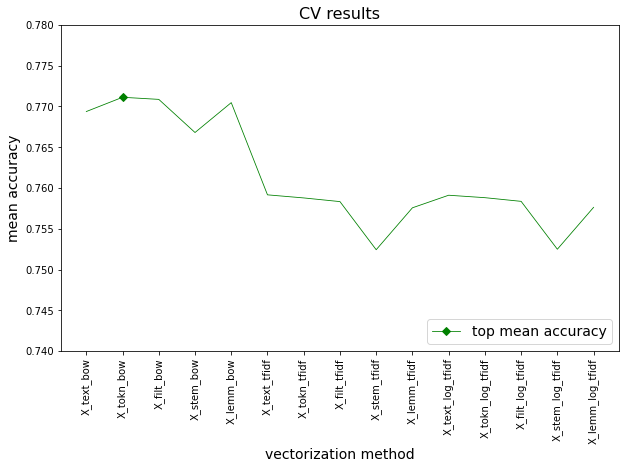

Elapsed time: 97.9674 seconds


In [12]:
plot_mean_cv_results(NB_clf, Xs, y, Xnames, ylim=[.74,.78])

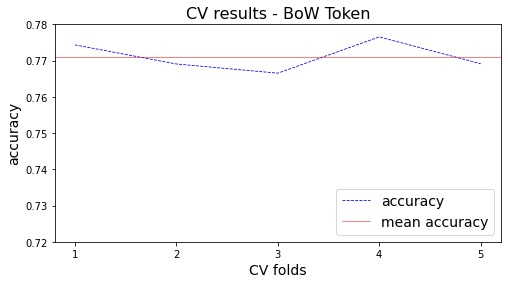

Elapsed time: 6.6650 seconds


In [13]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', ylim=[.72,.78])

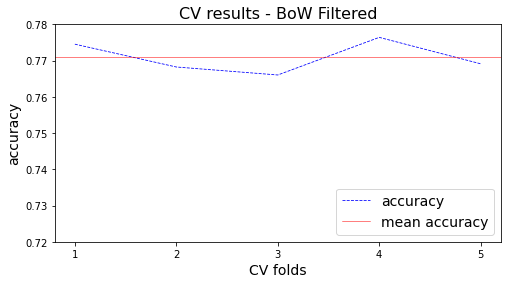

Elapsed time: 6.3933 seconds


In [14]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', ylim=[.72,.78])

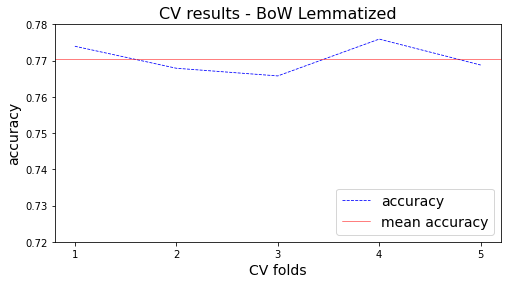

Elapsed time: 6.4069 seconds


In [15]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', ylim=[.72,.78])

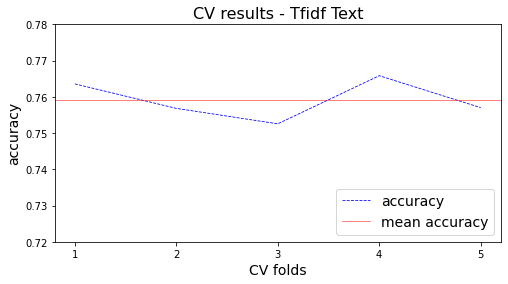

Elapsed time: 6.7830 seconds


In [16]:
# check Tfidf for comparison
plot_cv_results(NB_clf, X_text_tfidf, y, 'Tfidf Text', ylim=[.72,.78])

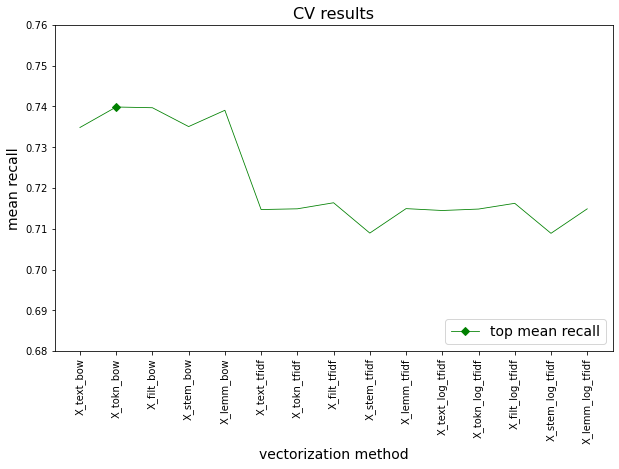

Elapsed time: 99.4352 seconds


In [17]:
plot_mean_cv_results(NB_clf, Xs, y, filenames, scoring='recall', ylim=[.68,.76])

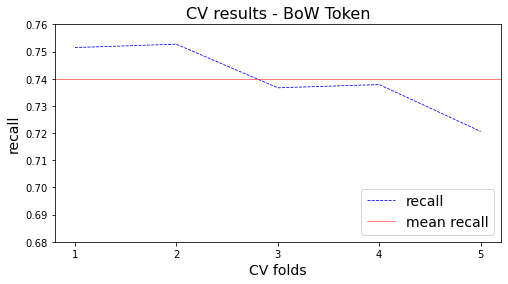

Elapsed time: 3.0590 seconds


In [18]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='recall', ylim=[.68,.76])

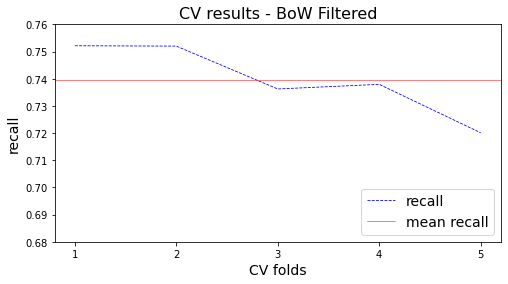

Elapsed time: 2.8800 seconds


In [19]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='recall', ylim=[.68,.76])

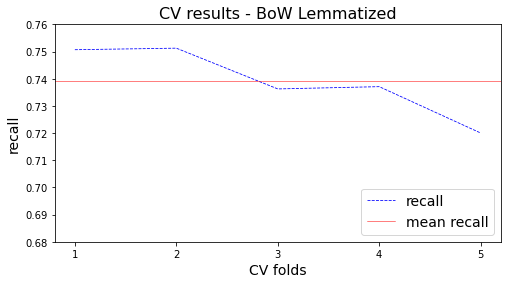

Elapsed time: 2.8641 seconds


In [20]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', scoring='recall', ylim=[.68,.76])

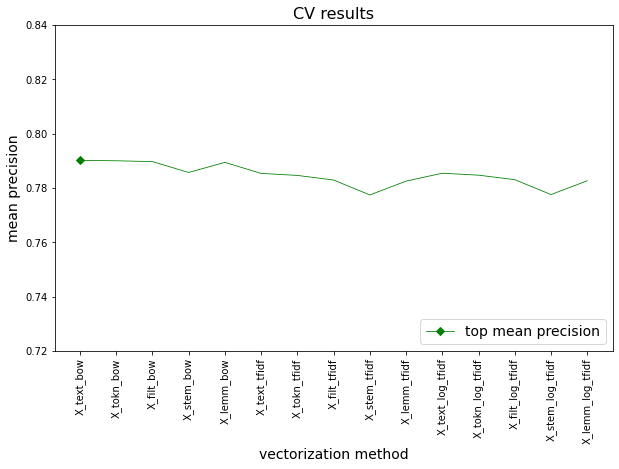

Elapsed time: 43.4245 seconds


In [21]:
plot_mean_cv_results(NB_clf, Xs, y, filenames, scoring='precision', ylim=[.72,.84])

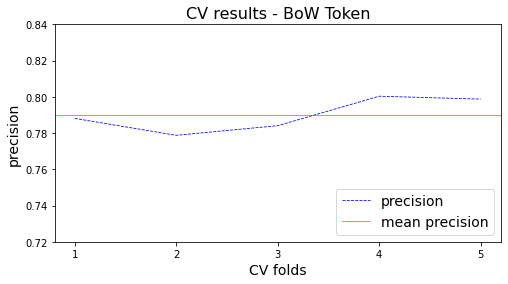

Elapsed time: 3.0445 seconds


In [22]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='precision', ylim=[.72,.84])

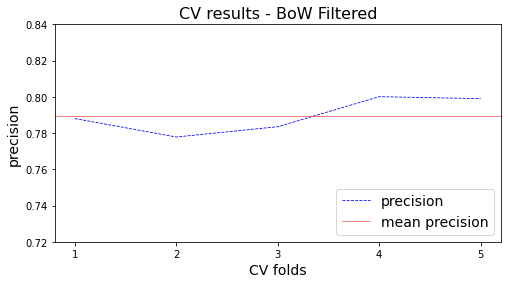

Elapsed time: 2.9081 seconds


In [23]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='precision', ylim=[.72,.84])

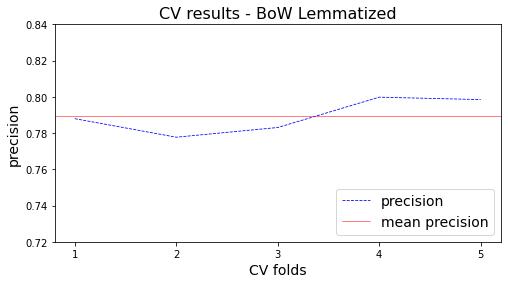

Elapsed time: 2.8645 seconds


In [24]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', scoring='precision', ylim=[.72,.84])

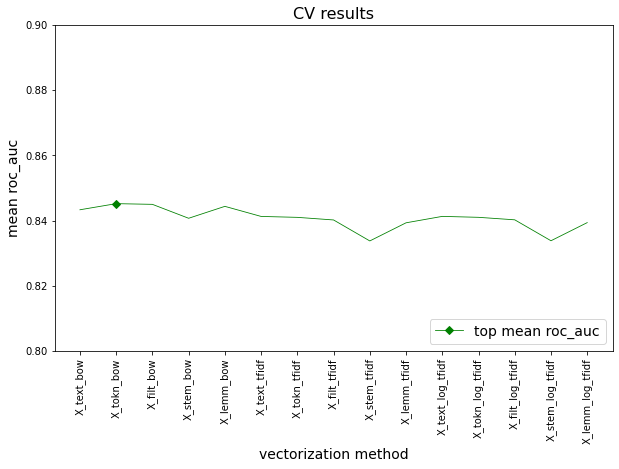

Elapsed time: 45.6496 seconds


In [25]:
plot_mean_cv_results(NB_clf, Xs, y, filenames, scoring='roc_auc', ylim=[.8,.9])

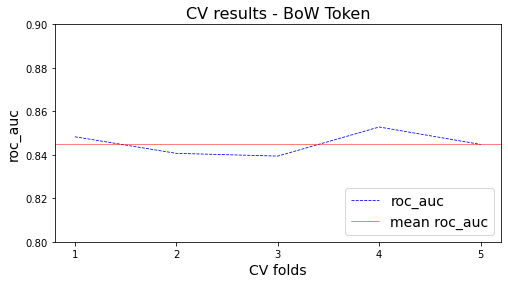

Elapsed time: 3.7005 seconds


In [26]:
plot_cv_results(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='roc_auc', ylim=[.8,.9])

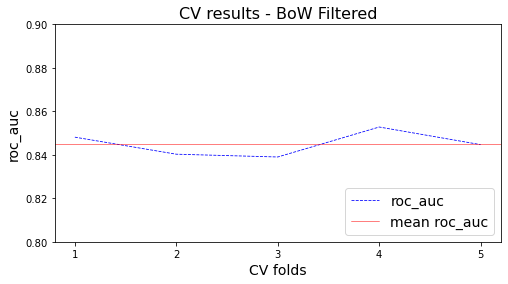

Elapsed time: 3.4015 seconds


In [27]:
plot_cv_results(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='roc_auc', ylim=[.8,.9])

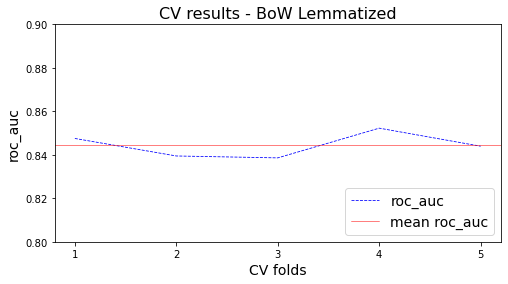

Elapsed time: 3.0679 seconds


In [28]:
plot_cv_results(NB_clf, X_lemm_bow, y, 'BoW Lemmatized', scoring='roc_auc', ylim=[.8,.9])

**Assessment**

For Naive Bayes, the BoW tokenized, filtered, or lemmatized versions have the best qualities overall.

#### Tokenized BoW

In [29]:
# split full tokenized set 
X_train, X_test, y_train, y_test = \
train_test_split(X_tokn_bow, y, test_size=0.2, random_state=42)

In [30]:
y_scores = cross_val_predict(NB_clf, X_train, y_train, cv=5)

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

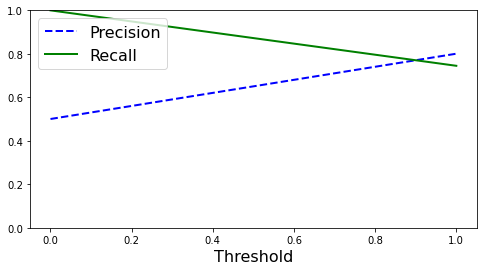

In [32]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

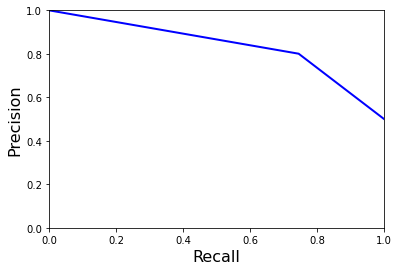

In [33]:
plt.figure(figsize=(6, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [34]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

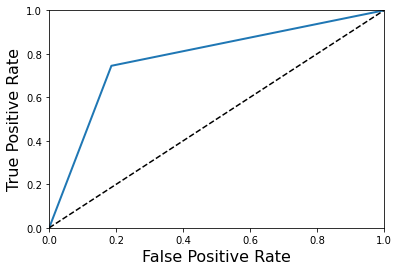

In [35]:
plt.figure(figsize=(6, 4))
plot_roc_curve(fpr, tpr)
plt.show()

####  Learning Curves


Since we have ~1,6M rows I'll only plot every 100k-th data point.

In [36]:
@timer
def plot_learning_curves(model, X, y, Xname):
    """Plot the learning curves for train and validation sets:
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_acc, val_acc = [], []

    # plot every 100,000th data point
    data_granularity = 100000
    xs = []
    for m in range(1, X_train.shape[0], data_granularity):        
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        val_acc.append(accuracy_score(y_val, y_val_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, round(X_train.shape[0]/data_granularity, 0), 0.6, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, np.sqrt(val_acc), 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", Xname]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

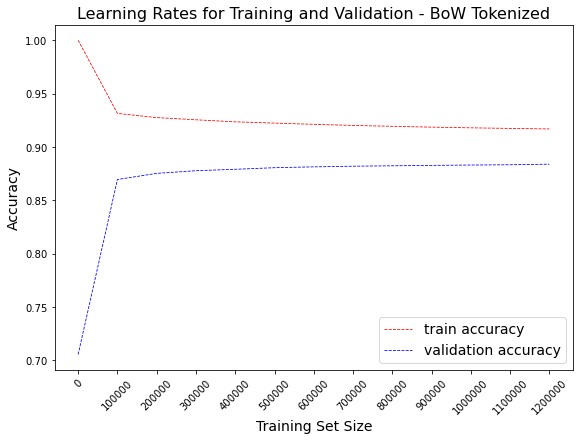

Elapsed time: 7.9819 seconds


In [39]:
plot_learning_curves(NB_clf, X_tokn_bow, y, 'BoW Tokenized')

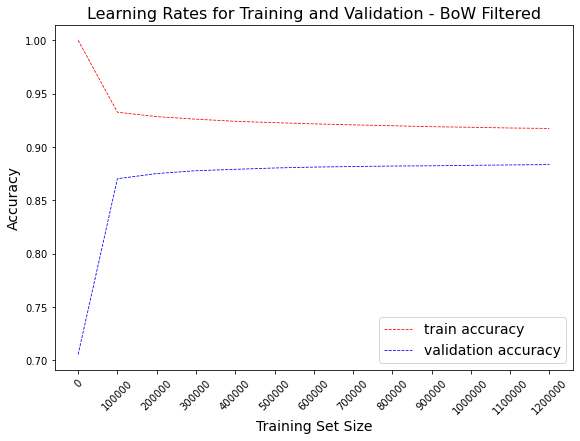

Elapsed time: 7.4766 seconds


In [41]:
plot_learning_curves(NB_clf, X_filt_bow, y, 'BoW Filtered')

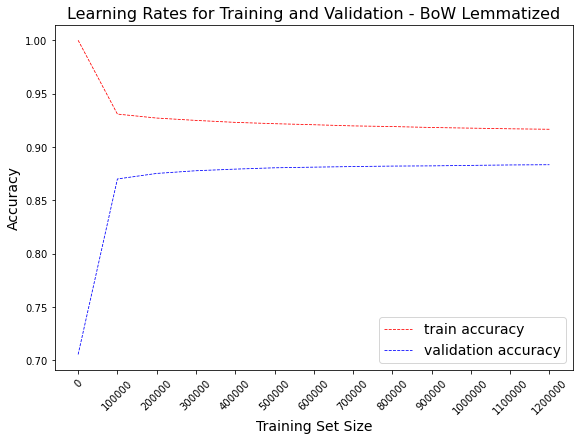

Elapsed time: 7.5188 seconds


In [40]:
plot_learning_curves(NB_clf, X_lemm_bow, y, 'BoW Lemmatized')

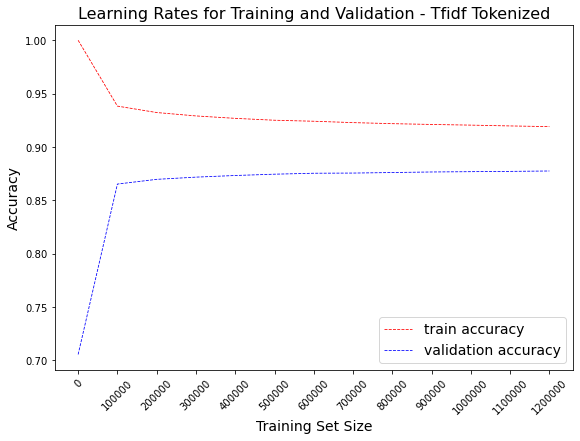

Elapsed time: 7.9780 seconds


In [42]:
plot_learning_curves(NB_clf, X_tokn_tfidf, y, 'Tfidf Tokenized')


- TODO: add graph interpretations

---